In [1]:
%matplotlib  inline

import matplotlib.pyplot as pyplot
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point
from scipy.spatial import cKDTree
import numpy
import pandas
import geopandas as gp
import csv
import shapely.geometry
import mapclassify
import ipywidgets

pandas.options.display.max_rows = 25

In [5]:
# Extracting the polygon of mainland Portugal from the map shapefile, dropping Azores and Madeira
portugal_gdf = gp.read_file('portugal_map_shapefile/DATA/Countries/PT/NUTS_3.shp', index = False)
azores = portugal_gdf[(portugal_gdf['NUTS_LABEL'] == 'Região Autónoma dos Açores')].index
madeira = portugal_gdf[(portugal_gdf['NUTS_LABEL'] == 'Região Autónoma da Madeira')].index
portugal = portugal_gdf.drop(azores.union(madeira))

# Converting to the standard Coordinate Reference System of Portugal
portugal = portugal.to_crs(epsg = 3763)

# Unifying all polygons of Portugal; this will allow testing whether all the schools and 
# restaurants coordinates are within mainland Portugal
portugal_polygon = portugal.unary_union

In [6]:
# Extracting the polygons of the denser metropolitan areas; keeping only the relevant information
urban_gdf = gp.read_file('portugal_map_shapefile/DATA/Countries/PT/BuiltupA.shp', index = False)
urban = urban_gdf[['geometry']]

# Converting to the standard Coordinate Reference System of Portugal
urban = urban.to_crs(epsg = 3763)

# Excluding Azores and Madeira; note that, as part of the urban polygons overflow the portugal
# polygons, 'intersects' is a better choice than 'within'
urban = urban[urban['geometry'].intersects(portugal_polygon) == True]

# Unifying all polygons of urban
urban_polygon = urban.unary_union

In [8]:
# Extractig the points of the villages; keeping only the relevant information
villages_gdf = gp.read_file('portugal_map_shapefile/DATA/Countries/PT/BuiltupP.shp', index = False)
villages = villages_gdf[['NAMA1', 'geometry']].rename({'NAMA1':'Nome'}, axis = 1)

# Converting to the standard Coordinate Reference System of Portugal
villages = villages.to_crs(epsg = 3763)

# Excluding Azores and Madeira
villages = villages[villages['geometry'].within(portugal_polygon) == True]

In [12]:
# Extracting data from csv files
bk_raw = pandas.read_csv('points_of_interest/burger_king.csv', sep = ';', index_col = False)
mcd_raw = pandas.read_csv('points_of_interest/mcdonalds.csv', sep = ';', index_col = False)
tel_raw = pandas.read_csv('points_of_interest/telepizza.csv', sep = ';', index_col = False)
schools_raw = pandas.read_csv('points_of_interest/schools.csv', sep = ';', index_col = False)

# Extracting geometric points from the coordinates
bk_geo = [Point(xy) for xy in zip(bk_raw['Lon'], bk_raw['Lat'])]
mcd_geo = [Point(xy) for xy in zip(mcd_raw['Lon'], mcd_raw['Lat'])]
tel_geo = [Point(xy) for xy in zip(tel_raw['Lon'], tel_raw['Lat'])]
schools_geo = [Point(xy) for xy in zip(schools_raw['Lon'], schools_raw['Lat'])]

# Building GeoDataFrames; note that the CRS of the raw data differs from the standard, and
# this must be taken into account when importing
bk_gdf = gp.GeoDataFrame(bk_raw, geometry = bk_geo, crs='epsg:4258')
mcd_gdf = gp.GeoDataFrame(mcd_raw, geometry = mcd_geo, crs = 'epsg:4258')
tel_gdf = gp.GeoDataFrame(tel_raw, geometry = tel_geo, crs = 'epsg:4258')
schools_gdf = gp.GeoDataFrame(schools_raw, geometry = schools_geo, crs = 'epsg:4258')

# Converting to the standard Coordinate Reference System of Portugal
bk_crs = bk_gdf.to_crs(epsg=3763)
mcd_crs = mcd_gdf.to_crs(epsg=3763)
tel_crs = tel_gdf.to_crs(epsg=3763)
schools_crs = schools_gdf.to_crs(epsg=3763)

# Test for points outside Portugal (not needed anymore)
#bk_crs[bk_crs['geometry'].within(portugal_polygon) == False]
#mcd_crs[mcd_crs['geometry'].within(portugal_polygon) == False]
#schools_crs[schools_crs['geometry'].within(portugal_polygon) == False]
#tel_crs[tel_crs['geometry'].within(portugal_polygon) == False]


In [26]:
# Adding the corresponding NUT to the schools and restaurants GeoDataFrames. Note that the 
# following operation can only stores one geometry, and since we need to store the geometry
# of the points (and not of the NUTs polygons), the reference has to be 'right'

def adding_nut(original_variable):
    joined = gp.sjoin(portugal, original_variable, predicate='contains', how='right')
    if original_variable is schools_crs:
        relevant_info = joined[['Nome', 'Lat', 'Lon','NUTS_LABEL', 'geometry']]
    else:
        relevant_info = joined[['Tipo','Nome', 'Lat', 'Lon','NUTS_LABEL', 'geometry']]
    reordered = relevant_info.sort_values(by='NUTS_LABEL').reset_index(drop=True)
    return (reordered)

bk = adding_nut(bk_crs)
mcd = adding_nut(mcd_crs)
tel = adding_nut(tel_crs)
schools = adding_nut(schools_crs)

# Grouping the 3 restaurants in a single variable
rest = pandas.concat([bk, mcd, tel], ignore_index=True)
rest = rest.sort_values(by='NUTS_LABEL').reset_index(drop=True)


# Aggregate schools and restaurants according to NUT, so to make choropleth maps. Note that
# here the reference has to be 'left', since we need the geometry of the NUTs polygons
def join_by_nut(original_variable):
    joined = gp.sjoin(portugal, original_variable, predicate='contains', how='left')
    relevant_info = joined[['Nome', 'NUTS_LABEL', 'geometry']]
    per_nut = relevant_info.dissolve(by='NUTS_LABEL', aggfunc='count')
    reordered = per_nut.reset_index().rename({'Nome': 'count'}, axis=1)
    return (reordered)

schools_nut = join_by_nut(schools_crs)
bk_nut = join_by_nut(bk_crs)
mcd_nut = join_by_nut(mcd_crs)
tel_nut = join_by_nut(tel_crs)
rest_nut = join_by_nut(rest.drop(columns='NUTS_LABEL'))

In [ ]:
# confirmar se há coordenadas iguais, o que há, porque schools de ensinos diferentes e, como tal, com 
# nomes diferentes podem estar no mesmo edifício

#schools[schools['geometry'].duplicated(keep=False)] 

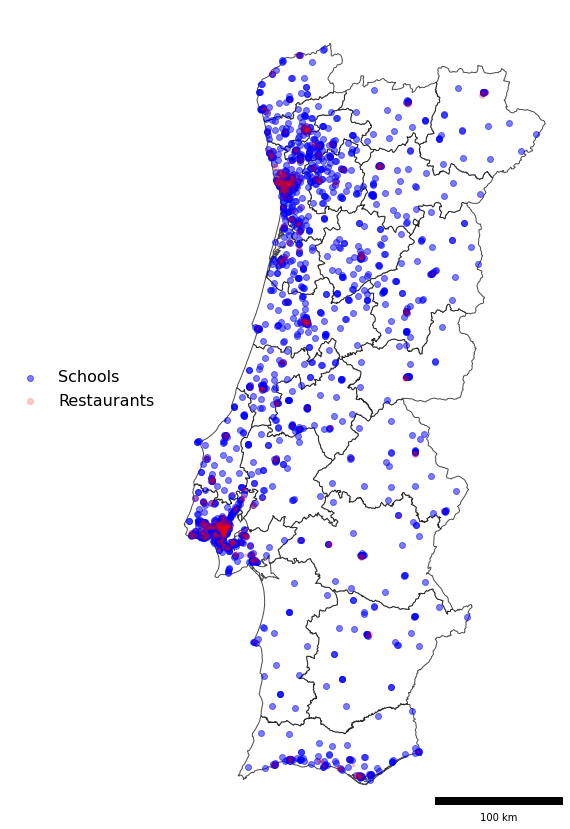

In [28]:
#grafico DEPOIS de mudar as coordenadas para UTM com unidades em metros
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(15, 15))

ax.set_axis_off()
portugal.plot(ax=ax, edgecolor='k', alpha= 0.7, facecolor='white', figsize=(15,15))
schools.plot(ax=ax, color='blue', alpha=0.5, label='Schools')
bk.plot(ax=ax, color='red', alpha= 0.2, label ='Restaurants')
mcd.plot(ax=ax, color='red', alpha=0.2, markersize=7)
tel.plot(ax=ax, color='red', alpha= 0.2, markersize=7)
ax.legend(fontsize=16,
         loc=(-0.4, 0.5),
         frameon=False)

scalebar = ScaleBar(dx=1, length_fraction=0.4, location='lower right', color='black',sep=7, pad=0, border_pad=0)
pyplot.gca().add_artist(scalebar)



#pp.title('urban', fontweight='bold')



#tirar os eixos mas manter um background cor diferente
#ax.set_facecolor((0, 0, 0, 0.05))
#ax.set_axis_off()
#ax.add_artist(ax.patch)
#ax.patch.set_zorder(-1)



#grafico1.set(xlim=(-100000, -80000), ylim=(-115000,-95000)) #lisboa 


#grafico1.set(xlim=(-150000, 170000), ylim=(-310000,285000))
#grafico1.set(xlim=(-130000, -55000), ylim=(-150000,-50000)) #lisboa 
#grafico1.set(xlim=(-60000, 0), ylim=(140000,180000)) #porto

#teste pontos
#grafico1.set(xlim=(-60000, 0), ylim=(90000,180000))
#schools.loc[[0], 'geometry'].plot(ax=grafico1, color='blue', alpha=1, markersize=15)
#rest.loc[[1], 'geometry'].plot(ax=grafico1, color='black', alpha=1)

In [ ]:
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(15, 15))

ax.set_axis_off()
portugal.plot(ax=ax, edgecolor='k', alpha= 0.7, facecolor='white', figsize=(15,15))
urban.plot(ax=ax, color='red', alpha=0.8)

#Not all handles can be turned into legend entries automatically, so it is often necessary to create an artist which can
#ver em https://matplotlib.org/tutorials/intermediate/legend_guide.html
red_patch = mpatches.Patch(color='red', label='urban')


ax.legend(handles=[red_patch],
          fontsize=16,
         loc=(-0.4, 0.5),
         frameon=False)

scalebar = ScaleBar(dx=1, length_fraction=0.4, location='lower right', color='black',sep=7, pad=0, border_pad=0)
pyplot.gca().add_artist(scalebar)

In [ ]:
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(15, 15))

ax.set_axis_off()
portugal.plot(ax=ax, edgecolor='k', alpha= 0.7, facecolor='white', figsize=(15,15))
villages.plot(ax=ax, color='crimson', facecolor='none', label='Vilas')
ax.legend(fontsize=20,
         loc=(-0.4, 0.5),
         frameon=False)

scalebar = ScaleBar(dx=1, length_fraction=0.4, location='lower right', color='black',sep=7, pad=0, border_pad=0)
pyplot.gca().add_artist(scalebar)

In [ ]:
#distribuiçao nacional das schools e de cada restaurante, por NUT
fig, (g2, g3, g4, g5, g6) = pyplot.subplots(nrows=1, ncols=5, figsize=(20, 16))
pyplot.tight_layout()

grafico2 = schools_nut.plot(ax=g2, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico3 = bk_nut.plot(ax=g3, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico4 = mcd_nut.plot(ax=g4, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico5 = tel_nut.plot(ax=g5, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico6 = rest_nut.plot(ax=g6, column='count', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')

<h1></h1>
<h1>OBJECTIVO 1</h1>
<h2>Determinar, para cada escola em Portugal continental, qual a proximidade ao estabelecimento de fast-food (EFF) mais próximo</h2>

In [ ]:
#mudei os nomes das entradas para Capitalized
#acrescentei o tipo de rest nos csv dos mcd e tel
#padronizei os labels das colunas
#comparei visualmente no mapa para ver se batia certo


#retirado de https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe

def ckdnearest(gdA, gdB):
    nA = numpy.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = numpy.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pandas.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pandas.Series(dist, name='dist')], axis=1)
    gdf['dist'] = gdf['dist'] / 1000  #conversao de m para km
    return gdf

prox = ckdnearest(schools.drop(columns=['Lat', 'Lon']).rename({'Nome':'ESCOLA'}, axis =1), rest.drop(columns=['Lat', 'Lon', 'NUTS_LABEL']))

In [ ]:
# agregar schools e restaurantes por NUT para poder fazer choropleth
# criar as estatisticas por NUTs

prox_mean = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), predicate='contains', how='left')[['NUTS_LABEL','geometry','ESCOLA','Nome','dist']].dissolve(by='NUTS_LABEL', aggfunc='mean').reset_index().rename({'dist': 'mean'}, axis=1)
prox_median = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), predicate='contains', how='left')[['NUTS_LABEL','geometry','ESCOLA','Nome','dist']].dissolve(by='NUTS_LABEL', aggfunc='median').reset_index().rename({'dist': 'median'}, axis=1)
prox_min = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), predicate='contains', how='left')[['NUTS_LABEL','geometry','dist']].dissolve(by='NUTS_LABEL', aggfunc='min').reset_index().rename({'dist': 'min'}, axis=1)
prox_max = geopandas.sjoin(portugal, prox.drop(columns=['NUTS_LABEL']), predicate='contains', how='left')[['NUTS_LABEL','geometry','dist']].dissolve(by='NUTS_LABEL', aggfunc='max').reset_index().rename({'dist': 'max'}, axis=1)

prox_nut = prox_mean.merge(prox_min.drop(columns='geometry'), on='NUTS_LABEL').merge(prox_median.drop(columns='geometry'), on='NUTS_LABEL').merge(prox_max.drop(columns='geometry'), on='NUTS_LABEL')

In [ ]:
prox_nut

In [ ]:
@ipywidgets.interact
def show_articles_more_than(column=['median', 'min'], x=(0, 35, 1)):
    return prox_nut.loc[prox_nut[column] < x]

In [ ]:
#fig, (g7, g8, g9) = pyplot.subplots(nrows=1, ncols=3, figsize=(20, 16))
#usamos a mediana pois ha outliers
pyplot.tight_layout()

grafico7 = prox_nut.plot(column='median', figsize=(20,16), legend=True, scheme='FisherJenks', cmap='Greens_r', edgecolor='k')
grafico7.set_axis_off()
#grafico8 = prox_nut.plot(ax=g8, column='min', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens_r', edgecolor='k')
#grafico9 = prox_nut.plot(ax=g9, column='max', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens_r', edgecolor='k')
#fig.canvas.toolbar_visible = False
#fig.canvas.header_visible = False
#fig.canvas.resizable = True

In [ ]:
seaborn.distplot(prox_nut['min'], rug=True)

<h1></h1>
<h1>OBJECTIVO 2</h1>
<h2>Determinar, para cada escola em Portugal continental, quantos EFF estão a curta distância (raios de 5 e de 10min a pé)</h2>
<h1>SEEMS TO BE WORKING UNTIL HERE</h1>


In [ ]:
# Para cada escola, criar um raio de 400m e de 800m e contar quantos rest estão nesse círculos
i = 0
raio = schools[:]  # slice op para copiar o conteúdo e não linkar à variável antiga
raio['400m'] = ''  # criar novas duas colunas vazias
raio['800m'] = ''

for i in range(len(schools)):
    raio.loc[i,'400m'] = len(rest[rest['geometry'].within(schools['geometry'][i].buffer(400))])
    raio.loc[i,'800m'] = len(rest[rest['geometry'].within(schools['geometry'][i].buffer(800))])

raio

In [ ]:
# agregar dados raio por NUT para poder fazer choropleth
# soma
raio_nut = geopandas.sjoin(portugal, raio.drop(columns=['NUTS_LABEL']), predicate='contains', how='left')[['NUTS_LABEL','geometry','Nome','400m','800m']].dissolve(by='NUTS_LABEL', aggfunc='sum').reset_index()


# média de restaurantes no raio especificado para as schools de cada NUT
raio_mean = geopandas.sjoin(portugal, raio.drop(columns=['NUTS_LABEL']), predicate='contains', how='left')[['NUTS_LABEL','geometry','400m','800m']]
raio_mean[['400m', '800m']] = raio_mean[['400m', '800m']].apply(pandas.to_numeric) # por algum motivo que desconheço, estas colunas aparecem como objectos e impossibilitam a obtenção da média, pelo que tenho de converter em números
raio_mean = raio_mean.dissolve(by='NUTS_LABEL', aggfunc='mean').reset_index().rename({'400m': '400m_mean', '800m': '800m_mean'}, axis=1)

#juntar
raio_nut = raio_nut.merge(raio_mean.drop(columns=['geometry']), on='NUTS_LABEL')
raio_nut

In [ ]:
fig, (g12, g13) = pp.subplots(nrows=1, ncols=2, figsize=(20, 16))
#fig, (g10, g11, g12, g13) = pp.subplots(nrows=1, ncols=4, figsize=(20, 16))
pp.tight_layout()

#grafico10 = raio_nut.plot(ax=g10, column='400m', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
#grafico11 = raio_nut.plot(ax=g11, column='800m', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico12 = raio_nut.plot(ax=g12, column='400m_mean', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')
grafico13 = raio_nut.plot(ax=g13, column='800m_mean', figsize=(5,5), legend=True, scheme='FisherJenks', cmap='Greens', edgecolor='k')

grafico12.set_axis_off()
grafico13.set_axis_off()

<h1></h1>
<h1>OBJECTIVO 3</h1>
<h2>Determinar se a localização dos EFF apresenta depêndencia espacial da localização das schools (ou seja, se os EFFs exibem um padrão de clustering em redor das schools)</h2>

- random mcd, bk e tel dentro dos buffers das villages?
- ver se ha aleatoriedade ou se há tendendecia de clustering em volta das schools estatisticamente significativa

Kcross inohomgenous nao executval no python? Tive que exportar para R
extraí as "coordenadas" da geometria para celulas à parte
exportei para shapefile
converti em ppp no R (ver https://github.com/jlevente/publications/blob/master/cross-k/calc_crossk.R)

fiz a Kcross inhomegenous com envelope:
    raio 1500m
    lambdaX = villages_ppm (para ter em consideração a maior probabilidade de calhar junto a vilas)
    nrank=1 (para definir como min e max do envelope o n-esimo valor mínimo e o nésimo valor maximo
    global = TRUE (para homegenizar as curvas e dar um uma probabilidade?)
    correction='translation' (? resulta!)

<s>Fiz exactamente o mesmo, mas com Lcross inhomegenous, pois esta permite ter um gráfico mais facilmente interpretavel (pois tem menor variação com o r?)
Acrescentei na expressao do gráfico ".-r ~ r", para que a recta da H0 fosse horizontal (e não diagonal)</s>

Queria acrescentar as urban à heterogeneidade, mas sendo polígonos torna-se complicado.
Nao consigo misturar polygons com pontos, pois ha infinitos pontos dentro de um polygon e vou distorcer a intensidade

Como tal, vou criar 2 analises de K functions: 
    uma fora das zonas urban, window = portugal - urban. tenho de retirar todos os pontos dentro das areas urban e so considerar os outros (atencao à aresta!!)
    a outra dentro das areas urban, em que window = urban


ver se faz diferença usar na intesnidade (lambdaX) o ppm ou a density

falta saber como fazer cloropeth disto


In [ ]:
# Colocar na mesma dataframe as schools e os restaurantes para poder passar a ppp. 
# Note-se que é necessário fazer a distinção entre os dois tipos de ponto de cada dataframe resultante, pelo que
# é necessário acrescentar o tipo para poder fazer a distincao dos pontos schools vs restaurante no R na funcao ppp

temp_schools = schools.drop(columns=['Lat', 'Lon'])
temp_schools.insert(loc=0, column='Tipo', value='escola')

# bk, mcd, tel
uniao_schools_bk = pandas.concat([bk.drop(columns=['Lat', 'Lon']), temp_schools], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)
uniao_schools_mcd = pandas.concat([mcd.drop(columns=['Lat', 'Lon']), temp_schools], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)
uniao_schools_tel = pandas.concat([tel.drop(columns=['Lat', 'Lon']), temp_schools], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)

# para os restaurantes no geral
# Note-se que aqui é preciso acrescentar o tipo da variável restaurante, para distinguir das schools, e aqui
# já não importa a distinção entre diferentes tipos de restaurante

temp_rest = rest.drop(columns=['Tipo','Lat', 'Lon'])
temp_rest.insert(loc=0, column ='Tipo', value='restaurante')
uniao_schools_rest = pandas.concat([temp_rest, temp_schools], ignore_index=True).sort_values(by='Tipo').reset_index(drop=True)

In [ ]:
uniao_schools_rest

In [ ]:
#verificar que tantos os restaurantes, como as schools como as villages ou estão dentro ou fora das areas urban, 
#de forma a não perder os que poderiam estar nas bordas

for a in (villages, uniao_schools_bk, uniao_schools_mcd, uniao_schools_tel, uniao_schools_rest):
    print(len(a[a.within(urban_polygon)]) + len(a[a.disjoint(urban_polygon)]) == len(a))

In [ ]:
#separar dentro das areas urban vs fora
uniao_schools_rest_urban = uniao_schools_rest[uniao_schools_rest.within(urban_polygon)]
uniao_schools_rest_rural = uniao_schools_rest[uniao_schools_rest.disjoint(urban_polygon)]

villages_urban = vilas[vilas.within(urban_polygon)]
villages_rural = vilas[vilas.disjoint(urban_polygon)]

In [ ]:
# Extração das coordenadas x e y da geometria dos pontos (note-se que estão em CRS diferente das lat e lon originais!)

def extrair_xy(lista):
    x = [x for x,y in zip(lista['geometry'].x, lista['geometry'].y)]
    y = [y for x,y in zip(lista['geometry'].x, lista['geometry'].y)]
    lista.insert(loc=len(lista.columns), column='x', value=x)
    lista.insert(loc=len(lista.columns), column='y', value=y)
    
extrair_xy(uniao_schools_bk)
extrair_xy(uniao_schools_mcd)
extrair_xy(uniao_schools_tel)

extrair_xy(villages_urban)
extrair_xy(villages_rural)
extrair_xy(uniao_schools_rest_urban)
extrair_xy(uniao_schools_rest_rural)

In [ ]:
#pt_sem_urban
rural = portugal[:][['NUTS_LABEL','geometry']]
rural['geometry'] = portugal.difference(urban_polygon)

In [ ]:
# exportar para shapefile a ser lida n R
portugal[['NUTS_LABEL', 'geometry']].to_file('shapefiles/portugal.shp', driver='ESRI Shapefile')
rural.to_file('shapefiles/rural.shp', driver='ESRI Shapefile')
urban.to_file('shapefiles/urban.shp', driver='ESRI Shapefile')

villages_urban.to_file('shapefiles/vilas_urban.shp', driver='ESRI Shapefile')
villages_rural.to_file('shapefiles/vilas_rural.shp', driver='ESRI Shapefile')

uniao_schools_bk.to_file('shapefiles/bk.shp', driver='ESRI Shapefile')
uniao_schools_mcd.to_file('shapefiles/mcd.shp', driver='ESRI Shapefile')
uniao_schools_tel.to_file('shapefiles/tel.shp', driver='ESRI Shapefile')
uniao_schools_rest.to_file('shapefiles/rest.shp', driver='ESRI Shapefile')
uniao_schools_rest_rural.to_file('shapefiles/rest_rural.shp', driver='ESRI Shapefile')
uniao_schools_rest_urban.to_file('shapefiles/rest_urban.shp', driver='ESRI Shapefile')